In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def find_node_by_id(nodes, id):
    for node in nodes:
        if node.id == id:
            return node
    print(f"Cannot find node with id = {id}")
    return None

In [3]:
class node:
    def __init__(self, id, x, y):
        self.id = id
        self.x = x
        self.y = y
    def print(self):
        print(f"node {self.id} at ({self.x},{self.y})")

In [4]:
class element:
    def __init__(self, id, node_i, node_f):
        self.id = id
        self.nodes_ids = [node_i.id, node_f.id]
        self.xs = [node_i.x, node_f.x]
        self.ys = [node_i.y, node_f.y]
        self.length = np.sqrt((self.xs[1] - self.xs[0])**2 + (self.ys[1] - self.ys[0])**2)
        self.column = ((self.xs[1] - self.xs[0])**2) < 1e-6

    def plot(self):
        plt.plot(self.xs, self.ys, "-k")
        if self.column:
            plt.text(self.xs[0] + 0.15 * self.length, self.ys[0] + 0.5*self.length, f"{self.id}", c="k")
        else:
            plt.text(self.xs[0] + 0.5 * self.length, self.ys[0] - 0.35*self.length, f"{self.id}", c="k")

In [5]:
class frame:
    def __init__(self, num_bays, num_floors, bay_length, floor_height, elements_per_bay, elements_per_floor):
        self.num_bays = num_bays
        self.num_floors = num_floors
        self.bay_length = bay_length
        self.floor_height = floor_height
        self.elements_per_bay = elements_per_bay
        self.elements_per_floor = elements_per_floor
        self.basic_count()

    def basic_count(self):
        self.nodes_per_column_line = self.num_floors*self.elements_per_floor + 1
        self.nodes_per_full_bay = self.num_floors*(self.elements_per_bay - 1)

        self.nodes_per_column = self.elements_per_floor - 1
        self.nodes_per_bay = self.elements_per_bay - 1

        self.dx = self.bay_length/self.elements_per_bay
        self.dy = self.floor_height/self.elements_per_floor
        self.num_nodes = self.nodes_per_column_line * (self.num_bays + 1) + self.nodes_per_full_bay*(self.num_bays)
        
    def calculate_vertices(self):
        self.vertices = []
        for column_i in np.arange(0,self.num_bays + 1):
            self.vertices.append([])
            for floor_i in np.arange(0, self.num_floors + 1):
                id = 1 + floor_i*(self.elements_per_floor) + column_i*self.nodes_per_column_line + column_i*self.nodes_per_full_bay
                self.vertices[column_i].append(node(id, column_i*self.bay_length, floor_i*self.floor_height))
    
    def calculate_bay_nodes(self):
        self.bay_nodes = []    
        for column_line_i in np.arange(0, self.num_bays):
            starting_vertices = self.vertices[column_line_i]
            self.bay_nodes.append([])
            for vertix_i in np.arange(1, self.num_floors + 1):
                id = (column_line_i + 1)*self.nodes_per_column_line + (column_line_i) *self.nodes_per_full_bay + (vertix_i - 1) * self.nodes_per_bay
                x0 = starting_vertices[vertix_i].x
                y0 = starting_vertices[vertix_i].y
                for node_i in np.arange(1,self.nodes_per_bay + 1):
                    id = id + 1
                    x = x0 + node_i*self.dx
                    y = y0
                    self.bay_nodes[column_line_i].append(node(id, x, y))

    def calculate_column_nodes(self):
        self.column_nodes = []
        for column_line_i in np.arange(0, self.num_bays  + 1):
            self.column_nodes.append([])
            for vertix_i in np.arange(0, self.num_floors):
                id = self.vertices[column_line_i][vertix_i].id
                x0 = self.vertices[column_line_i][vertix_i].x
                y0 = self.vertices[column_line_i][vertix_i].y
                for node_i in np.arange(1,self.nodes_per_column + 1):
                    id = id + 1
                    x = x0 
                    y = y0 + node_i*self.dy
                    self.column_nodes[column_line_i].append(node(id, x, y))
                
    def find_bay_nodes(self, bay, floor):
        
        bay_nodes = []

        starting_node = 1 + floor*(self.nodes_per_column + 1) + (bay - 1)*self.nodes_per_column_line + (bay - 1)*self.nodes_per_full_bay
        ending_node = starting_node + self.nodes_per_column_line + self.nodes_per_full_bay
        bay_nodes.append(starting_node)
        
        starting_bay_node = bay*self.nodes_per_column_line + (bay - 1)*self.nodes_per_full_bay + (floor - 1)*self.nodes_per_bay 
        for node_i in np.arange(1, self.nodes_per_bay + 1):    
            bay_nodes.append(starting_bay_node + node_i)
        bay_nodes.append(ending_node)
        return bay_nodes
    

    def get_vertix_id(self, column_line, floor):
        return 1 + floor*(self.elements_per_floor) + column_line*self.nodes_per_column_line + column_line*self.nodes_per_full_bay
    
    def get_vertices_ids(self):
        vertices_ids = []
        for floor_i in np.arange(0, self.num_floors + 1):
            for column_line_i in np.arange(0, self.num_bays + 1):
                vertices_ids.append(self.get_vertix_id(column_line_i, floor_i))
        return vertices_ids

    def get_beam_node_ids(self, bay, floor, include_vertices = False):
        if ((floor < 1) or (bay < 1)):
            raise ValueError(f"Floor = {floor} and Bay = {bay}, but neither can be less than 1.")
        starting_id = bay*self.nodes_per_column_line + (bay - 1)*self.nodes_per_full_bay + (floor - 1) * self.nodes_per_bay
        nodes = []
        if include_vertices:
            nodes.append(self.get_vertix_id(bay - 1, floor))

        for node_i in np.arange(1,self.nodes_per_bay + 1):
            nodes.append(starting_id + node_i)

        if include_vertices:
            nodes.append(self.get_vertix_id(bay, floor))
        return nodes

    def get_column_node_ids(self, column_line, floor):
        starting_id = 1 + column_line*self.nodes_per_column_line + floor*self.elements_per_floor + column_line*self.nodes_per_full_bay
        nodes = []
        for node_i in np.arange(1,self.nodes_per_column + 1):
            nodes.append(starting_id + node_i)
        return nodes

    def get_column_line_node_ids(self, column_line):
        nodes = []
        for floor_i in np.arange(0, self.num_floors):
            nodes.append(self.get_vertix_id(column_line, floor_i))
            column_node_ids = self.get_column_node_ids(column_line, floor_i)
            nodes.extend(column_node_ids)
        nodes.append(self.get_vertix_id(column_line, self.num_floors))
        return nodes
    
    def get_beam_line_node_ids(self, floor, get_vertices = True):
        nodes = []
        for bay_i in np.arange(1, self.num_bays + 1):
            if get_vertices:
                nodes.append(self.get_vertix_id(bay_i - 1, floor))
            bay_node_ids = self.get_beam_node_ids(bay_i, floor)
            nodes.extend(bay_node_ids)
            if get_vertices:
                nodes.append(self.get_vertix_id(bay_i, floor))
        return sorted(list(set(nodes)))
    
    def create_columns_nodes(self):
        nodes = []
        for column_line_i in np.arange(0, self.num_bays + 1):
            node_ids = self.get_column_line_node_ids(column_line_i)
            x_0 = column_line_i*self.bay_length
            y_0 = 0.0
            x = x_0
            y = y_0
            for node_id in node_ids:
                nodes.append(node(node_id, x, y))
                y = y + self.dy
        return nodes
    
    def create_beam_nodes(self):
        nodes = []
        vertices = self.get_vertices_ids()
        for floor_i in np.arange(1, self.num_floors + 1):
            node_ids = self.get_beam_line_node_ids(floor_i, get_vertices=True)
            x_0 = 0.0
            y_0 = floor_i*self.floor_height
            x = x_0
            y = y_0
            for node_id in node_ids:
                if not(node_id in vertices):
                    nodes.append(node(node_id, x, y))
                x = x + self.dx
        return nodes
    
    def map_elements(self):
        elements_map = []
        element_id = 0

        for bay_i in np.arange(1, self.num_bays + 1):
            # first column line
            node_ids = self.get_column_line_node_ids(bay_i - 1)
            for node_id_i in np.arange(0, len(node_ids) - 1):
                element_id = element_id + 1
                elements_map.append((element_id, [node_ids[node_id_i], node_ids[node_id_i + 1]]))
            # beams on each floor
            for floor_i in np.arange(1, self.num_floors + 1):
                node_ids = self.get_beam_node_ids(bay_i, floor_i, include_vertices=True)
                for node_id_i in np.arange(0, len(node_ids) - 1):
                    element_id = element_id + 1    
                    elements_map.append((element_id, [node_ids[node_id_i], node_ids[node_id_i + 1]]))
        # last column line
        node_ids = self.get_column_line_node_ids(self.num_bays)
        for node_id_i in np.arange(0, len(node_ids) - 1):
            element_id = element_id + 1    
            elements_map.append((element_id, [node_ids[node_id_i], node_ids[node_id_i + 1]]))
        return elements_map

    def create_elements(self):
        elements_map = self.map_elements()
        nodes = self.create_beam_nodes()
        nodes.extend(self.create_columns_nodes())
        elements = []
        for elem_node_pair in elements_map:
            node_i = find_node_by_id(nodes, elem_node_pair[1][0])
            node_f = find_node_by_id(nodes, elem_node_pair[1][1])
            elements.append(element(elem_node_pair[0], node_i, node_f))
        return elements  




    # plotting 
    def plot_vertices(self):
        for column_line in self.vertices:
            for vertix in column_line:
                plt.scatter(vertix.x, vertix.y, c="r")
                plt.text(vertix.x + self.bay_length*0.1, vertix.y - self.floor_height*0.2, f"{vertix.id}", c="r")
    
    def plot_bay_nodes(self):
        for column_line in self.bay_nodes:
            for vertix in column_line:
                plt.scatter(vertix.x, vertix.y, c="b")
                plt.text(vertix.x, vertix.y + self.floor_height*0.1, f"{vertix.id}", c="b")

    def plot_column_nodes(self):
        for column_line in self.column_nodes:
            for vertix in column_line:
                plt.scatter(vertix.x, vertix.y, c="g")
                plt.text(vertix.x - self.bay_length*0.15, vertix.y, f"{vertix.id}", c="g")



In [6]:
def plot_column_nodes(nodes, bay_length, floor_height):
    for node in nodes:
        plt.scatter(node.x, node.y, c="g")
        plt.text(node.x - bay_length*0.15, node.y, f"{node.id}", c="g")

def plot_beam_nodes(nodes, bay_length, floor_height):
    for node in nodes:
        plt.scatter(node.x, node.y, c="b")
        plt.text(node.x, node.y + floor_height*0.1, f"{node.id}", c="b")

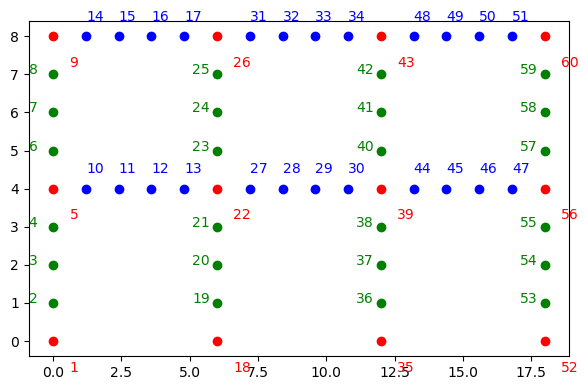

In [7]:
n_bays = 3
n_floors = 2
a_frame = frame(num_bays = n_bays, num_floors = n_floors, 
                bay_length = 6, floor_height = 4, 
                elements_per_bay = 5, elements_per_floor = 4)
a_frame.calculate_vertices()
a_frame.calculate_bay_nodes()
a_frame.calculate_column_nodes()
a_frame.plot_vertices()
a_frame.plot_bay_nodes()
a_frame.plot_column_nodes()
plt.gcf().set_size_inches(n_bays*2, n_floors*2)
plt.tight_layout()
plt.savefig("frame.png")

In [8]:
column_nodes = a_frame.create_columns_nodes()
beam_nodes = a_frame.create_beam_nodes()
elements = a_frame.create_elements()

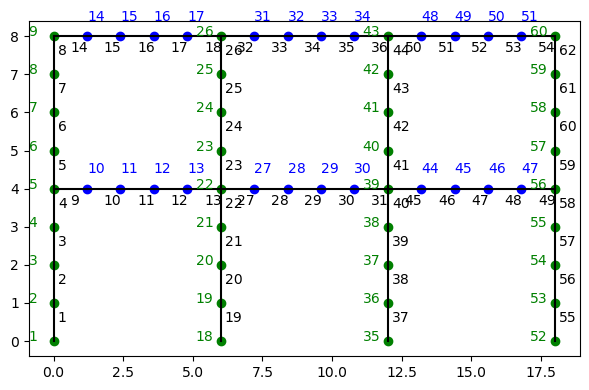

In [15]:
plot_column_nodes(column_nodes, a_frame.bay_length, a_frame.floor_height)
plot_beam_nodes(beam_nodes, a_frame.bay_length, a_frame.floor_height)
for element in elements:
    element.plot()
plt.gcf().set_size_inches(n_bays*2, n_floors*2)
plt.tight_layout()
plt.savefig("frame_elements.png")

In [10]:
a_frame.get_column_node_ids(4,1)

[74, 75, 76]

In [11]:
a_frame.get_beam_node_ids(1,3)

[18, 19, 20, 21]

In [12]:
a_frame.get_vertix_id(0, 0)

1

In [13]:
a_frame.find_bay_nodes(2, 1)

[22, 27, 28, 29, 30, 39]

In [14]:
bay = 1
floor = 2
nodes_per_column = a_frame.nodes_per_column
nodes_per_column_line = a_frame.nodes_per_column_line
nodes_per_full_bay = a_frame.nodes_per_full_bay
starting_node = 1 + floor*(nodes_per_column + 1) + (bay - 1)*nodes_per_column_line + (bay - 1)*nodes_per_full_bay

starting_node + nodes_per_column_line + nodes_per_full_bay

26